# Introduction and scope
In this notebook you will start implemeting a forward model relating first backscatter and later also emissivity and brightness temperature at microwave frequencies to some geophysical parameters.
Here we are going to concentrate here on the dependency of $\sigma_0$ on
- the roughness spectrum
- the radar frequency (wavelength)
- the observation geometry

In [2]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as mpl
import matplotlib.cm as cm
import pandas as pd
import os
from scipy import interpolate as interp
mpl.rcParams['font.size'] = 12

# Simple roughness spectra
As seen in the theory, we can characterize the roughness by its spectrum. We will start with the two models given in the reader. For a Gaussian autocorrelation function we have
$$
S_G(k_x,k_y) = \sigma_h^2 \frac{l^2}{\pi} e^{-(k_x^2+k_y^2)l^2/4}.
$$
where $k_x$ and $k_y$ are the wave-numbers in the x and y direction, where for convenience we can assume that the radar looks in the x-direction. The parameter $l$ is the correlation length, and $\sigma_h$ would be the rms height perturbation of the surface w.r.t. a flat one. For an exponential autocorrelation function we have the spectrum
$$
S_e(k_x,k_y) = \sigma_h^2 \frac{2l^2}{\pi\left(1+(k_x^2+k_y^2)l^2 \right)^{3/2}}
$$

**In the cell below, write function or functions to compute these two spectra**

-628.3185307179587 628.3185307179587


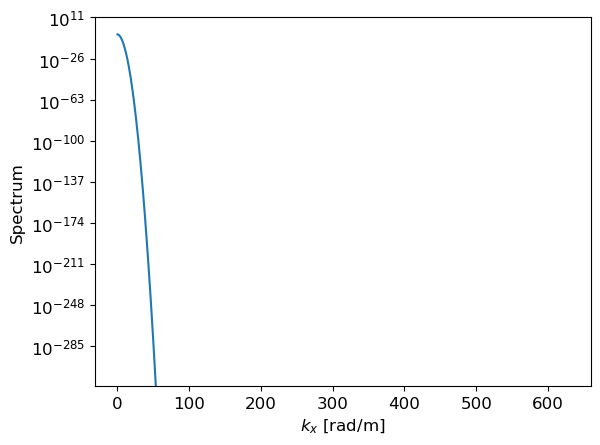

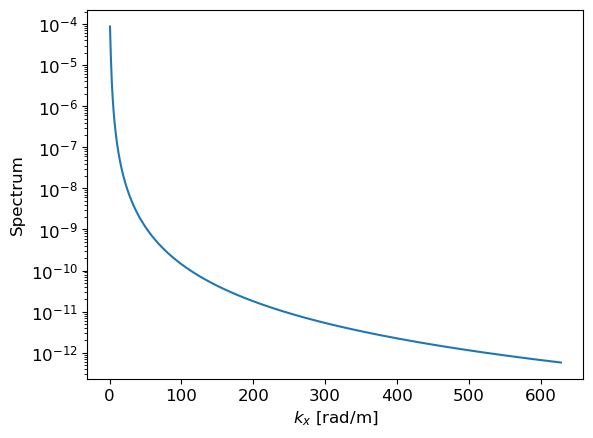

In [14]:
# For example, complete the code below:
def GaussianSpectrum(kx, ky, sigma_h, l):
    # Do something... ideally your code works with both single values or with vectors or arrays
    # Here some dummy wrong code just to make an example plot
    k = kx**2 + ky**2
    S = (sigma_h**2)*((l**2)/np.pi)*np.exp(-(((k)*(l**2))/4))
    return S  


def ExponentialSpectrum(kx, ky, sigma_h, l):
    # Do something... ideally your code works with both single values or with vectors or arrays
    # Here some dummy wrong code just to make an example plot
    S = ((sigma_h**2)*2*(l**2))/(np.pi*((1+(kx**2 + ky**2)*l*l)**(3/2)))
    return S  

# Now represent the spectra.
# For example let us assume we are interested in scales going from 10 m to 1 cm
kmin = 2*np.pi/10
kmax = 2*np.pi/0.01

sigma_h = 0.015

print(-kmax,kmax)

# Since the spectrum is isotropic a 1D plot will do
kx = np.linspace(kmin, kmax, 1000)
l = 1
plt.figure()
plt.plot(kx, GaussianSpectrum(kx, 0, sigma_h, l))
plt.xlabel('$k_x$ [rad/m]')
plt.ylabel('Spectrum')
plt.yscale('log')
# plt.xscale('log')
plt.show()

# Exponential one
plt.figure()
plt.plot(kx, ExponentialSpectrum(kx,0, sigma_h, l))
plt.xlabel('$k_x$ [rad/m]')
plt.ylabel('Spectrum')
plt.yscale('log')
# plt.xscale('log')

# Small perturbation model
Now **implement a function that calculates the HH and VV polarized NRCS assuming the first ordder small perturbation model described in section 6.3.1. of the reader.**
The function should (or could) take as inputs:
- The radar frequency (which you need to calculate $k_0$)
- The angle of incidence
- The relative permitivity, $\epsilon_r$
- The function to calculate the spectrum (see discussion in cell below)
- $\sigma_h$
- The correlation length, l

In [15]:
# Your code comes here
def NRCS_SMP(f, theta_i, epsilon_r, spec_f, sigma_h, l):
    # You can pass a function as an argument to a function, so that you can call it
    # it from within another function
    # Here you would calculate k_B (equation 6.14)
    c = 2.99792458e8
    k0 =2*np.pi*f/c
    k_B = 2*k0*np.sin(theta_i*np.pi/180)
    S = spec_f(k_B, 0, sigma_h, l)
    # rest of your code
    alpha_hh = np.abs((epsilon_r-1)/((np.cos(theta_i) + np.sqrt(epsilon_r-np.sin(theta_i*np.pi/180)))**2))
    alpha_vv = np.abs(((epsilon_r-1)*((epsilon_r-1)*np.sin(theta_i*np.pi/180) + epsilon_r))/(((epsilon_r*np.cos(theta_i*np.pi/180))+np.sqrt(epsilon_r-np.sin(theta_i*np.pi/180)**2))**2))
    
    NRCS_hh = 4*np.pi*(k0**4)*(np.cos(np.radians(theta_i))**4)*(alpha_hh**2)*S
    NRCS_vv = 4*np.pi*(k0**4)*(np.cos(np.radians(theta_i))**4)*(alpha_vv**2)*S
    
    return NRCS_hh, NRCS_vv

Now we want to explore how the NRCS depends on the different paramters in our model. Here we are not yet interested in the dependence on $\epsilon_r$, so take some fixed value (for example you can assume we are looking at water) For that, do the following:
- **Fixing l=0.1 and $\sigma_h=0.01$ compute and plot $\sigma_{0,HH}$ and $\sigma_{0,VV}$ as a function of the angle of incidence varing this angle between 20 and 60 degree (remember to work in radians where needed, `np.radians()` is your friend). Do this for L-band, C-band and X-band. Compare and discuss the results.**
- **Investigate the impact of the parameter l on the NRCS. For example, you could plot the NRCS as a function of l, fixing the rest of paramters, for different wavelengths.**

### Comparing with different bands 

In [30]:
print(2.99792458e8/C_band)

0.05551712185185185


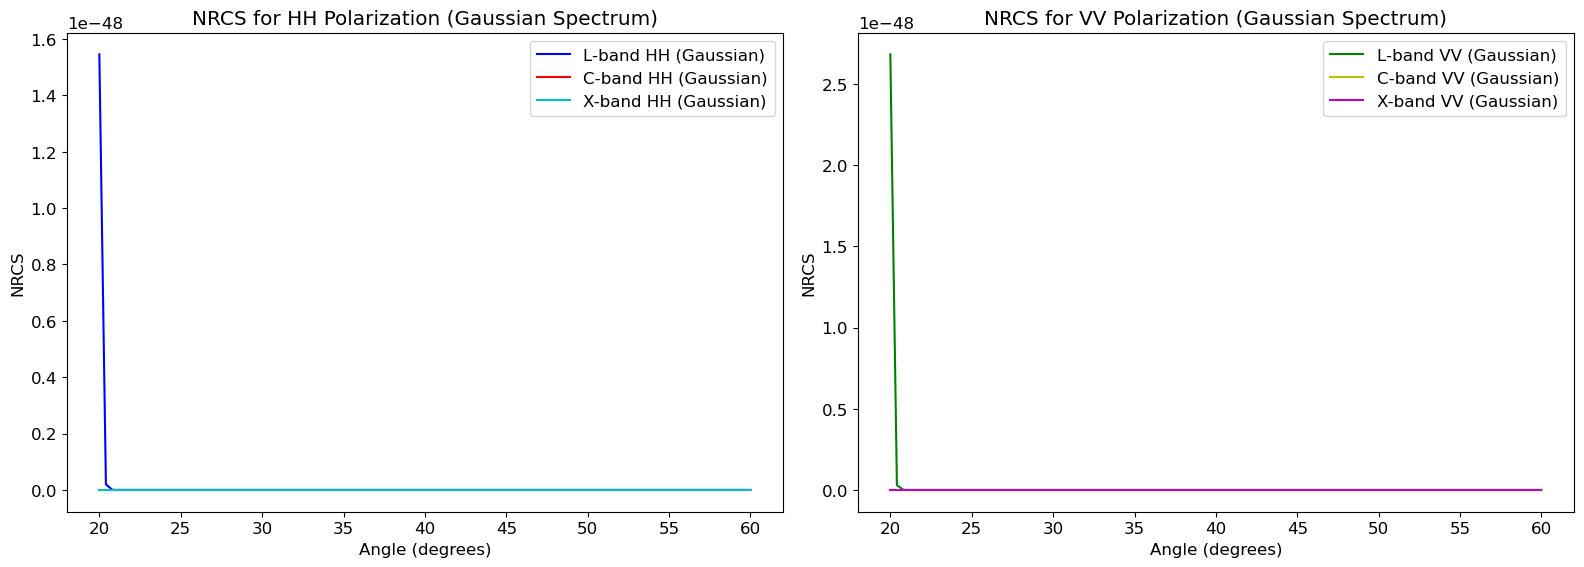

In [16]:
angles = np.linspace(20,60,100)

sigma_h = 0.01  # Surface height standard deviation (m)
l_fixed = 0.1  # Correlation length (m)
# epsilon_r = 80 - 0.5j  # Relative permittivity for water
epsilon_r = 80


L_band = np.mean((1e9, 2e9))
C_band = 5.4e9 
X_band = np.mean((8e9, 12e9))



# Using gaussian
l_NRCS_hh_g, l_NRCS_vv_g = NRCS_SMP(L_band, angles, epsilon_r, GaussianSpectrum, sigma_h, l)
c_NRCS_hh_g, c_NRCS_vv_g = NRCS_SMP(C_band, angles, epsilon_r, GaussianSpectrum, sigma_h, l)
x_NRCS_hh_g, x_NRCS_vv_g = NRCS_SMP(X_band, angles, epsilon_r, GaussianSpectrum, sigma_h, l)

# Create subplots for HH and VV polarizations
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for HH Polarization (Left plot) using Gaussian Spectrum
axs[0].plot(angles, l_NRCS_hh_g, label='L-band HH (Gaussian)', color='b')
axs[0].plot(angles, c_NRCS_hh_g, label='C-band HH (Gaussian)', color='r')
axs[0].plot(angles, x_NRCS_hh_g, label='X-band HH (Gaussian)', color='c')
axs[0].set_title('NRCS for HH Polarization (Gaussian Spectrum)')
axs[0].set_xlabel('Angle (degrees)')
axs[0].set_ylabel('NRCS')
axs[0].legend()

# Plot for VV Polarization (Right plot) using Gaussian Spectrum
axs[1].plot(angles, l_NRCS_vv_g, label='L-band VV (Gaussian)', color='g')
axs[1].plot(angles, c_NRCS_vv_g, label='C-band VV (Gaussian)', color='y')
axs[1].plot(angles, x_NRCS_vv_g, label='X-band VV (Gaussian)', color='m')
axs[1].set_title('NRCS for VV Polarization (Gaussian Spectrum)')
axs[1].set_xlabel('Angle (degrees)')
axs[1].set_ylabel('NRCS')
axs[1].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()





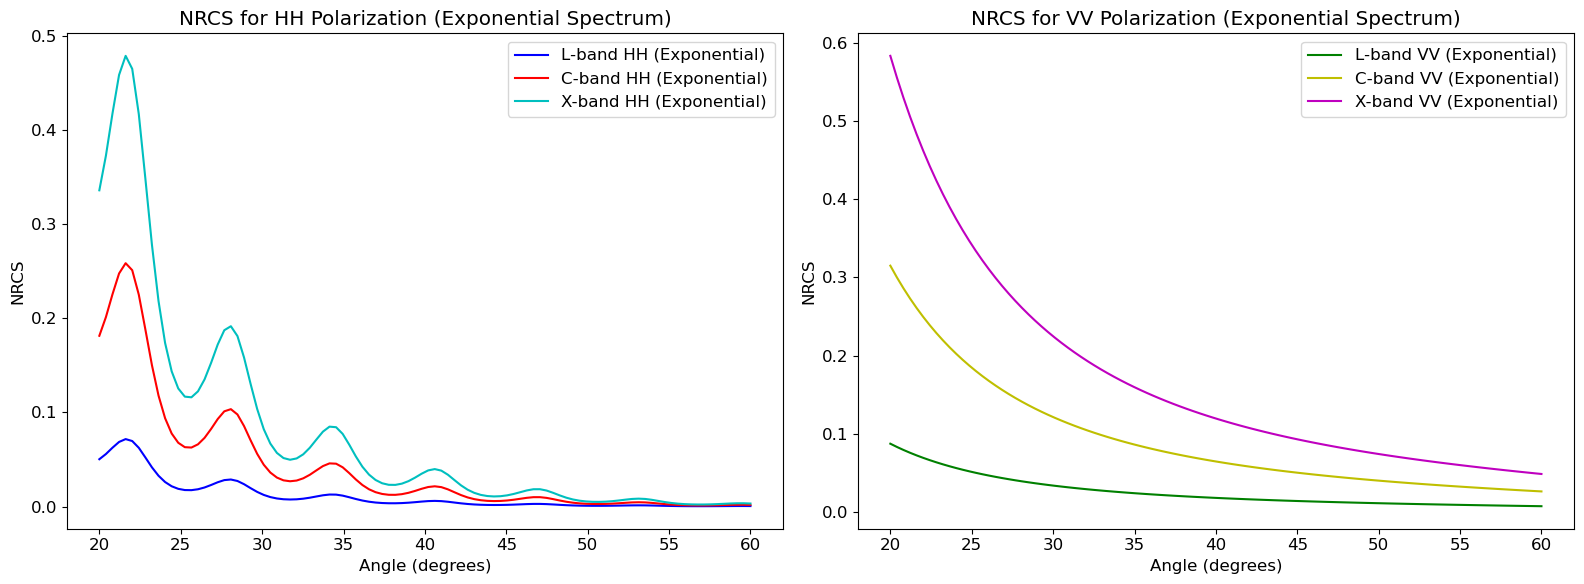

In [17]:
#Using exponential
l_NRCS_hh_e, l_NRCS_vv_e = NRCS_SMP(L_band, angles, epsilon_r, ExponentialSpectrum, sigma_h, l)
c_NRCS_hh_e, c_NRCS_vv_e = NRCS_SMP(C_band, angles, epsilon_r, ExponentialSpectrum, sigma_h, l)
x_NRCS_hh_e, x_NRCS_vv_e = NRCS_SMP(X_band, angles, epsilon_r, ExponentialSpectrum, sigma_h, l)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for HH Polarization (Left plot)
axs[0].plot(angles, l_NRCS_hh_e, label='L-band HH (Exponential)', color='b')
axs[0].plot(angles, c_NRCS_hh_e, label='C-band HH (Exponential)', color='r')
axs[0].plot(angles, x_NRCS_hh_e, label='X-band HH (Exponential)', color='c')
axs[0].set_title('NRCS for HH Polarization (Exponential Spectrum)')
axs[0].set_xlabel('Angle (degrees)')
axs[0].set_ylabel('NRCS')
axs[0].legend()

# Plot for VV Polarization (Right plot)
axs[1].plot(angles, l_NRCS_vv_e, label='L-band VV (Exponential)', color='g')
axs[1].plot(angles, c_NRCS_vv_e, label='C-band VV (Exponential)', color='y')
axs[1].plot(angles, x_NRCS_vv_e, label='X-band VV (Exponential)', color='m')
axs[1].set_title('NRCS for VV Polarization (Exponential Spectrum)')
axs[1].set_xlabel('Angle (degrees)')
axs[1].set_ylabel('NRCS')
axs[1].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

For exponential spectrum

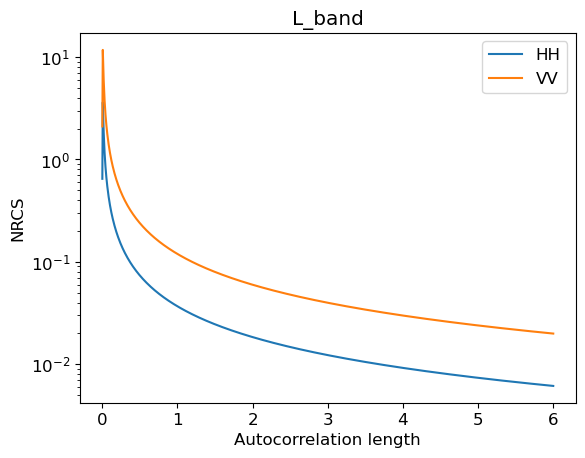

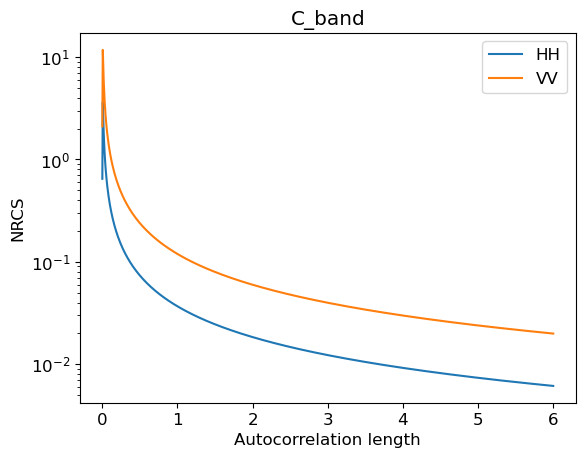

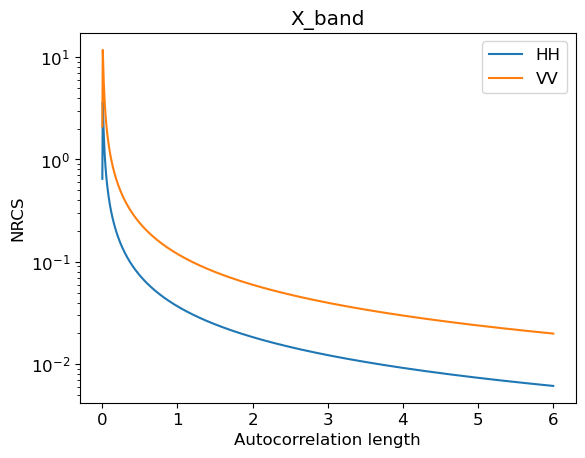

In [47]:
theta_i = 40
ls = np.linspace(0.001, 6, 1000)
names = ['L_band', 'C_band', 'X_band']
for indx, band in enumerate((L_band, C_band, X_band)):
    plt.figure()
    plt.title(f"{names[indx]}")
    NRCS_hh_g, NRCS_vv_g = NRCS_SMP(freq, theta_i, epsilon_r, ExponentialSpectrum, sigma_h, ls)
    plt.plot(ls, NRCS_hh_g, label= 'HH')
    plt.plot(ls, NRCS_vv_g, label= 'VV')
    plt.xlabel('Autocorrelation length')
    plt.yscale('log')
    plt.ylabel('NRCS')
    plt.legend()
    plt.show()


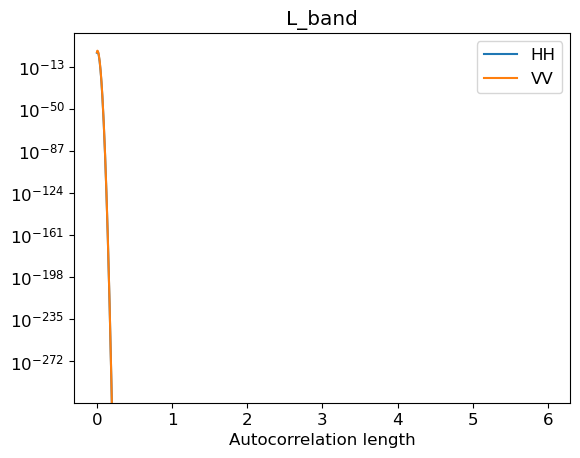

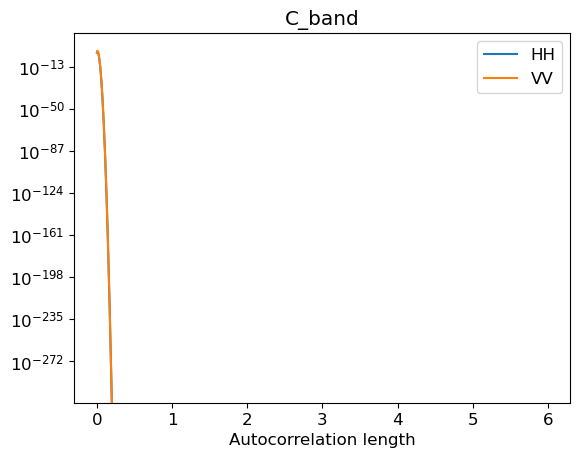

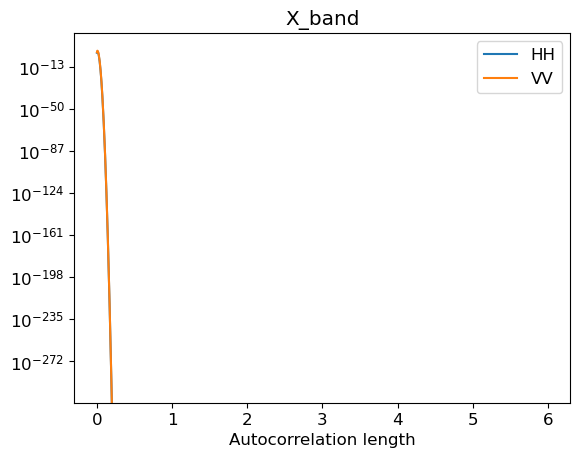

In [42]:
theta_i = 40
ls = np.linspace(0.001, 6, 1000)
names = ['L_band', 'C_band', 'X_band']
for indx, band in enumerate((L_band, C_band, X_band)):
    plt.figure()
    plt.title(f"{names[indx]}")
    NRCS_hh_g, NRCS_vv_g = NRCS_SMP(freq, theta_i, epsilon_r, GaussianSpectrum, sigma_h, ls)
    plt.plot(ls, NRCS_hh_g, label= 'HH')
    plt.plot(ls, NRCS_vv_g, label= 'VV')
    plt.xlabel('Autocorrelation length')
    plt.yscale('log')
    plt.legend()
    plt.show()

# Ocean scattering
The cell below (which you do not need to study) implements the so-called Elfouhaily spectrum. At the end we have implemented the function that you want to use
`elfouhaily_cart(kx, ky, alpha, U_10, fetch=500e3)`
which calculates the directional spectrum at the wavenumber $(k_x,k_y)$ assuming a 10 meter wind U_10 blowing in the direction alpha with respect to the x-direction. The code is a bit picky with respect what you give it as an input. kx and ky can be numbers or vectors, alpha and U_10 should be just numbers.

In [45]:
# Elfouhailiy spectrum
g=9.81

def __gamma_function( Omega_c ):
    # Eq. 3 (below)
    if (Omega_c > 0.84) and (Omega_c < 1.0):
        gamma = 1.7
    elif (Omega_c > 1.0) and (Omega_c < 5.0):
        gamma = 1.7 + 6. * np.log10( Omega_c )
    else:
        warnings.warn( 'Omega_c is out of range. Returning  value for 5.0', RuntimeWarning )
        gamma = 1.7 + 6. * np.log10( 5.0 )

    return gamma


def __alpha_m_function( ustar, c_m ):
    # Eq. 44
    if ustar < c_m:
        alpha_m = 1e-2 * (1. + np.log( ustar / c_m ))
    else:
        alpha_m = 1e-2 * (1. + 3. * np.log( ustar / c_m ))

    return alpha_m


def elfouhaily(k, U_10, fetch):
    rho = 1000.  # Density of water in kg/m^3
    S = 0.072  # Surface tension of water in N/m
    X_0 = 22e3  # Dimensionless fetch
    # Calculated variables
    k_m = 2 * np.pi / 0.017
    # Eq. 3 (below)
    k_0 = g / U_10 ** 2
    # Eq. 4 (below)
    X = k_0 * fetch
    # Eq. 37: Inverse wave age
    Omega_c = 0.84 * np.tanh( (X / X_0) ** (0.4) ) ** (-0.75)
    # Wave phase speed (assumes deep water)
    c = np.sqrt( g / k + S / rho * k )

    # B_l: Long-wave curvature spectrum
    # Note that in contrast to Elfouhaily's paper, the L_pm factor
    # is applied to the both B_l and B_h.

    # Eq. 3 (below)
    k_p = k_0 * Omega_c ** 2
    # Phase speed at the spectral peak
    c_p = np.sqrt( g / k_p + S / rho * k_p )
    # Eq. 32 (above): Inverse wave age parameter (dimensionless)
    Omega = U_10 / c_p
    # Eq. 34
    alpha_p = 6e-3 * np.sqrt( Omega )

    # Eq. 3 (below)
    sigma = 0.08 * (1. + 4. * Omega_c ** (-3.))
    Gamma = np.exp( -(np.sqrt( k / k_p ) - 1.) ** 2 / (2. * sigma ** 2) )
    # Eq. 3
    J_p = __gamma_function( Omega_c ) ** Gamma
    # Eq. 2
    L_pm = np.exp( -5. / 4. * (k_p / k) ** 2 )
    # Eq. 32
    F_p = L_pm * J_p * np.exp( -Omega / np.sqrt( 10. ) * (np.sqrt( k / k_p ) - 1.) )
    # Eq. 32
    B_l = 0.5 * alpha_p * c_p / c * F_p

    # B_s: Short-wave curvature spectrum
    # (McDaniel, 2001, above Equation 3.9)
    C_10 = (0.8 + 0.065 * U_10) * 1e-3
    # Eq. 61: Friction velocity
    ustar = np.sqrt( C_10 ) * U_10

    # Eq. 41 (above)
    c_m = np.sqrt( g / k_m + S / rho * k_m )
    # Eq. 41 (above)
    alpha_m = __alpha_m_function( ustar, c_m )
    # Eq. 41 with L_pm according to McDaniel, 2001 (in text below Equation 3.9)
    F_m = L_pm * np.exp( -0.25 * (k / k_m - 1.) ** 2 )
    # Eq. 40
    B_h = 0.5 * alpha_m * c_m / c * F_m

    # Eq. 30 (Final spectrum)
    return (B_l + B_h) / k ** 3



"""
Implementation of the directional function to construct a
directional wave spectrum, following Elfouhaily et al.
Elfouhaily T., Chapron B., and Katsaros K. (1997). "A unified
directional spectrum for long and short wind driven waves"
J. Geophys. Res. 102 15.781-96
LOG:
2011-08-26 Gordon Farquharson: Removed an extra factor of 2. the code that implements from Equation 49.
2013-01-25 Paco Lopez Dekker: Renormalized function so that the integral in theta gives 1 (instead of 0.5)
"""
def elfouhaily_spread( k, theta, U_10, fetch ):
    rho = 1000.  # Density of water in kg/m^3
    S = 0.072  # Surface tension of water in N/m
    X_0 = 22e3  # Dimensionless fetch
    # Eq. 3 (below)
    k_0 = g / U_10 ** 2
    # Eq. 4 (below)
    X = k_0 * fetch
    # Eq. 37
    Omega_c = 0.84 * np.tanh( (X / X_0) ** (0.4) ) ** (-0.75)
    cK = np.sqrt( g / k + S / rho * k )

    # Eq. 3 (below)
    k_p = k_0 * Omega_c ** 2
    cK_p = np.sqrt( g / k_p + S / rho * k_p )

    # Eq. 24
    k_m = np.sqrt( rho * g / S )
    cK_m = np.sqrt( g / k_m + S / rho * k_m )

    # (McDaniel, 2001, above Equation 3.9)
    C_10 = (0.8 + 0.065 * U_10) * 1e-3
    # Eq. 61
    ustar = np.sqrt( C_10 ) * U_10

    # Eq. 59
    a_0 = np.log( 2. ) / 4.
    a_p = 4.
    a_m = 0.13 * ustar / cK_m

    # Eq. 57
    Delta = np.tanh( a_0 + a_p * (cK / cK_p) ** 2.5 + a_m * (cK_m / cK) ** 2.5 )
    # Eq. 49
    G = np.where( np.logical_and(theta >= -np.pi / 2, theta < np.pi / 2.), (1. + Delta * np.cos( 2. * theta )) / (np.pi), 0 )

    return G

def elfouhaily_cart(kx, ky, alpha, U_10, fetch=500e3):
    '''
    kx and ky are the wavenumber components
    alpha is the wind direction with respect the x-axis, in radians!
    U_10 is the wind speed
    
    '''
    k = np.sqrt(kx**2 + ky**2)
    S_omni = elfouhaily(k, U_10, fetch)
    k_dir = np.arctan2(ky, kx)
    a1 = np.angle(np.exp(1j*(alpha-k_dir)))
    a2 = np.angle(np.exp(1j*(alpha-k_dir-np.pi)))
    D = (elfouhaily_spread( k, a1, U_10, fetch) + 
         elfouhaily_spread( k, a2, U_10, fetch))/2
    S = np.where(k==0, 0, S_omni * D / k)
    return S






    

Below you can find a plot as a function of $k_x$ for $k_y=0$

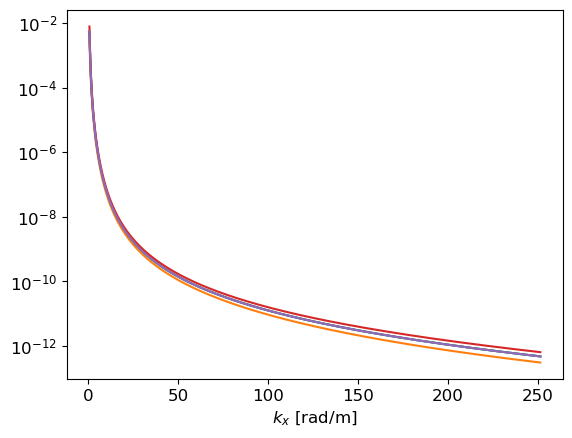

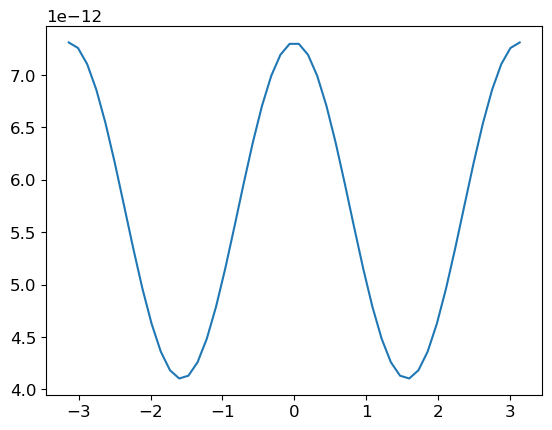

In [46]:
kmin = 2*np.pi/10
kmax = 2*np.pi/0.025
# Since the spectrum is isotropic a 1D plot will do
kx = np.linspace(kmin, kmax, 1000)

plt.figure()
for a in np.radians([-135,-90,-45,0,45]):
    S = elfouhaily_cart(kx,0,a,10)
    plt.plot(kx, S)
    
plt.yscale('log')
plt.xlabel('$k_x$ [rad/m]')
plt.figure()
plt.plot(np.linspace(-np.pi,np.pi),elfouhaily_cart(125,0,np.linspace(-np.pi,np.pi),10))


**Implement a function that calculates the NRCS as a function for a wind-driven ocean surface as a function of frequency, angle of incidence, $U_{10}$ and wind direction. Generate the follwing plots:**
- **C-band NRCS as function of angle of incidence fixing U=10 and $\alpha$=45 degree**.
- **C-band NRCS as function of wind-direction for $\theta_i$ set to 20, 30 and 40 degree, fixing U=10**.
- **C-band NRCS as function of wind-speed for $\theta_i$ set to 20, 30 and 40 degree, setting $\alpha$=45 degree**.